### DS5110 Project
### Group 5: Predicting Stock v. Cryptocurrency with Market Data
### Group Members: Cecile Johnson (hyj5qz), Nick Landi (nyl4gw), Elizabeth Lee (ewl3dv)
---

### Data Import and Preprocessing

In [2]:
# load modules
from pyspark.sql import SparkSession
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler 
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline  
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


from pyspark.ml.feature import StandardScaler

import os

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DateType

from pyspark.sql.functions import *

from pyspark.sql import functions as F

import pandas as pd
import numpy as np

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master("local") \
        .appName("pspark_test") \
        .getOrCreate()

In [5]:
sc = spark.sparkContext

In [6]:
os.chdir('/project/ds5559/group5_NL_EL_CJ')

In [7]:
# Setting Schema for crypto
crypto_schema = StructType([StructField('Date', DateType(), False), 
                            StructField('Open', FloatType(), False),
                            StructField('High', FloatType(), False),
                            StructField('Low', FloatType(), False),
                            StructField('Close', FloatType(), False),
                            StructField('Adj Close', FloatType(), False),
                            StructField('Volume', FloatType(), False)])

In [8]:
ETH_df = spark.read.csv('/project/ds5559/group5_NL_EL_CJ/ETH-USD-2.csv', inferSchema=False, header = True, schema=crypto_schema)
DOGE_df = spark.read.csv('/project/ds5559/group5_NL_EL_CJ/DOGE-USD-2.csv', inferSchema=False, header = True, schema=crypto_schema)
BTC_df = spark.read.csv('/project/ds5559/group5_NL_EL_CJ/BTC-USD-2.csv', inferSchema=False, header = True, schema=crypto_schema)

In [9]:
PFE_df = spark.read.csv('/project/ds5559/group5_NL_EL_CJ/PFE.csv', inferSchema=True, header = True)
SBUX_df = spark.read.csv('/project/ds5559/group5_NL_EL_CJ/SBUX.csv', inferSchema=True, header = True)
TSLA_df = spark.read.csv('/project/ds5559/group5_NL_EL_CJ/TSLA.csv', inferSchema=True, header = True)

In [10]:
# PFE schema
PFE_df = PFE_df.withColumn('Date', F.to_date(F.col('Date'),"yyyy-MM-dd"))
PFE_df = PFE_df.withColumn('Open', F.col('Open').cast('float'))
PFE_df = PFE_df.withColumn('High', F.col('High').cast('float'))
PFE_df = PFE_df.withColumn('Low', F.col('Low').cast('float'))
PFE_df = PFE_df.withColumn('Close', F.col('Close').cast('float'))
PFE_df = PFE_df.withColumn('Adj Close', F.col('Adj Close').cast('float'))
PFE_df = PFE_df.withColumn('Volume', F.col('Volume').cast('float'))

PFE_df.show(5)
PFE_df.printSchema()

+----------+---------+---------+---------+---------+---------+-----------+
|      Date|     Open|     High|      Low|    Close|Adj Close|     Volume|
+----------+---------+---------+---------+---------+---------+-----------+
|2020-06-16| 31.86907|32.220116|31.043644|31.688805| 29.66744|5.5616944E7|
|2020-06-17| 31.86907| 32.03985|31.612904|31.840607|29.809555|2.7509822E7|
|2020-06-18|31.565466|31.755219|31.290323|31.537003| 29.52532|3.2278856E7|
|2020-06-19|31.963947|32.011387| 31.42315| 31.70778|29.685204|4.3986264E7|
|2020-06-22| 31.62239|31.650854| 31.22391|31.413662|29.409847|2.3332504E7|
+----------+---------+---------+---------+---------+---------+-----------+
only showing top 5 rows

root
 |-- Date: date (nullable = true)
 |-- Open: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- Volume: float (nullable = true)



In [11]:
#SBUX_df
SBUX_df = SBUX_df.withColumn('Date', F.to_date(F.col('Date'),"yyyy-MM-dd"))
SBUX_df = SBUX_df.withColumn('Open', F.col('Open').cast('float'))
SBUX_df = SBUX_df.withColumn('High', F.col('High').cast('float'))
SBUX_df = SBUX_df.withColumn('Low', F.col('Low').cast('float'))
SBUX_df = SBUX_df.withColumn('Close', F.col('Close').cast('float'))
SBUX_df = SBUX_df.withColumn('Adj Close', F.col('Adj Close').cast('float'))
SBUX_df = SBUX_df.withColumn('Volume', F.col('Volume').cast('float'))

SBUX_df.show(5)
SBUX_df.printSchema()

+----------+-----+-----+-----+-----+---------+---------+
|      Date| Open| High|  Low|Close|Adj Close|   Volume|
+----------+-----+-----+-----+-----+---------+---------+
|2020-06-16|78.79|78.94|76.39|77.84| 75.42003|1.08901E7|
|2020-06-17|78.07|78.29|76.68| 77.1| 74.70303|6906700.0|
|2020-06-18|76.72|76.79| 75.8|76.31| 73.93759|8486000.0|
|2020-06-19|77.03|77.38|74.88| 75.4| 73.05588|1.25386E7|
|2020-06-22| 74.9|75.65|73.92| 75.4| 73.05588|8238600.0|
+----------+-----+-----+-----+-----+---------+---------+
only showing top 5 rows

root
 |-- Date: date (nullable = true)
 |-- Open: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- Volume: float (nullable = true)



In [12]:
#TSLA_df (tesla)
TSLA_df = TSLA_df.withColumn('Date', F.to_date(F.col('Date'),"yyyy-MM-dd"))
TSLA_df = TSLA_df.withColumn('Open', F.col('Open').cast('float'))
TSLA_df = TSLA_df.withColumn('High', F.col('High').cast('float'))
TSLA_df = TSLA_df.withColumn('Low', F.col('Low').cast('float'))
TSLA_df = TSLA_df.withColumn('Close', F.col('Close').cast('float'))
TSLA_df = TSLA_df.withColumn('Adj Close', F.col('Adj Close').cast('float'))
TSLA_df = TSLA_df.withColumn('Volume', F.col('Volume').cast('float'))

TSLA_df.show(5)
TSLA_df.printSchema()

+----------+-------+-------+-------+-------+---------+-----------+
|      Date|   Open|   High|    Low|  Close|Adj Close|     Volume|
+----------+-------+-------+-------+-------+---------+-----------+
|2020-06-16| 202.37|202.576|192.478|196.426|  196.426|7.0255504E7|
|2020-06-17|197.542|  201.0|196.514|198.358|  198.358|   4.9454E7|
|2020-06-18|  200.6| 203.84|198.894|200.792|  200.792|  4.87595E7|
|2020-06-19|202.556|203.194|198.268| 200.18|   200.18|  4.33985E7|
|2020-06-22| 199.99|201.776|198.004|198.864|  198.864|   3.1812E7|
+----------+-------+-------+-------+-------+---------+-----------+
only showing top 5 rows

root
 |-- Date: date (nullable = true)
 |-- Open: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- Volume: float (nullable = true)



In [13]:
# Adding a indicator column to differentiate between crypto currencies (1) and stocks (0)
ETH_df = ETH_df.withColumn("Currency_Type", lit(1))
DOGE_df = DOGE_df.withColumn("Currency_Type", lit(1))
BTC_df = BTC_df.withColumn("Currency_Type", lit(1))
PFE_df = PFE_df.withColumn("Currency_Type", lit(0))
SBUX_df = SBUX_df.withColumn("Currency_Type", lit(0))
TSLA_df = TSLA_df.withColumn("Currency_Type", lit(0))

In [14]:
# Adding a indicator column to differentiate between unique crypto and stocks 
ETH_df = ETH_df.withColumn("Currency_Name", lit("ETC"))
DOGE_df = DOGE_df.withColumn("Currency_Name", lit("DOGE"))
BTC_df = BTC_df.withColumn("Currency_Name", lit("BTC"))
PFE_df = PFE_df.withColumn("Currency_Name", lit("PFE"))
SBUX_df = SBUX_df.withColumn("Currency_Name", lit("SBUX"))
TSLA_df = TSLA_df.withColumn("Currency_Name", lit("TSLA"))

#### Adding Percentage Change Features

In [18]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

#Open
price_window = Window.partitionBy("Currency_Name").orderBy("Currency_Name")
combined_df = combined_df.withColumn("prev_value_open", F.lag(combined_df.Open).over(price_window))
combined_df = combined_df.withColumn("perc_diff_open", F.when(F.isnull((combined_df.Open - combined_df.prev_value_open)/combined_df.prev_value_open), 0).otherwise((combined_df.Open - combined_df.prev_value_open)/combined_df.prev_value_open))

In [19]:
#Close
price_window = Window.partitionBy("Currency_Name").orderBy("Currency_Name")
combined_df = combined_df.withColumn("prev_value_close", F.lag(combined_df.Close).over(price_window))
combined_df = combined_df.withColumn("perc_diff_close", F.when(F.isnull((combined_df.Close - combined_df.prev_value_close)/combined_df.prev_value_close), 0).otherwise((combined_df.Close - combined_df.prev_value_close)/combined_df.prev_value_close))

In [20]:
#High
price_window = Window.partitionBy("Currency_Name").orderBy("Currency_Name")
combined_df = combined_df.withColumn("prev_value_high", F.lag(combined_df.High).over(price_window))
combined_df = combined_df.withColumn("perc_diff_high", F.when(F.isnull((combined_df.High - combined_df.prev_value_high)/combined_df.prev_value_high), 0).otherwise((combined_df.High - combined_df.prev_value_high)/combined_df.prev_value_high))

In [21]:
#Low
price_window = Window.partitionBy("Currency_Name").orderBy("Currency_Name")
combined_df = combined_df.withColumn("prev_value_low", F.lag(combined_df.Low).over(price_window))
combined_df = combined_df.withColumn("perc_diff_low", F.when(F.isnull((combined_df.Low - combined_df.prev_value_low)/combined_df.prev_value_low), 0).otherwise((combined_df.Low - combined_df.prev_value_low)/combined_df.prev_value_low))

In [22]:
#Adj Close
price_window = Window.partitionBy("Currency_Name").orderBy("Currency_Name")
combined_df = combined_df.withColumn("prev_value_adjclose", F.lag(combined_df['Adj Close']).over(price_window))
combined_df = combined_df.withColumn("perc_diff_adjclose", F.when(F.isnull((combined_df['Adj Close'] - combined_df.prev_value_adjclose)/combined_df.prev_value_adjclose), 0).otherwise((combined_df['Adj Close'] - combined_df.prev_value_adjclose)/combined_df.prev_value_adjclose))

In [23]:
#Volume
price_window = Window.partitionBy("Currency_Name").orderBy("Currency_Name")
combined_df = combined_df.withColumn("prev_value_volume", F.lag(combined_df.Volume).over(price_window))
combined_df = combined_df.withColumn("perc_diff_volume", F.when(F.isnull((combined_df.Volume - combined_df.prev_value_volume)/combined_df.prev_value_volume), 0).otherwise((combined_df.Volume - combined_df.prev_value_volume)/combined_df.prev_value_volume))

In [24]:
combined_df.show(10)

+----------+-------+-------+-------+-------+---------+-----------+-------------+-------------+---------------+--------------------+----------------+--------------------+---------------+--------------------+--------------+--------------------+-------------------+--------------------+-----------------+--------------------+
|      Date|   Open|   High|    Low|  Close|Adj Close|     Volume|Currency_Type|Currency_Name|prev_value_open|      perc_diff_open|prev_value_close|     perc_diff_close|prev_value_high|      perc_diff_high|prev_value_low|       perc_diff_low|prev_value_adjclose|  perc_diff_adjclose|prev_value_volume|    perc_diff_volume|
+----------+-------+-------+-------+-------+---------+-----------+-------------+-------------+---------------+--------------------+----------------+--------------------+---------------+--------------------+--------------+--------------------+-------------------+--------------------+-----------------+--------------------+
|2020-06-16| 202.37|202.576|192

In [25]:
combined_df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Currency_Type: integer (nullable = false)
 |-- Currency_Name: string (nullable = false)
 |-- prev_value_open: float (nullable = true)
 |-- perc_diff_open: double (nullable = true)
 |-- prev_value_close: float (nullable = true)
 |-- perc_diff_close: double (nullable = true)
 |-- prev_value_high: float (nullable = true)
 |-- perc_diff_high: double (nullable = true)
 |-- prev_value_low: float (nullable = true)
 |-- perc_diff_low: double (nullable = true)
 |-- prev_value_adjclose: float (nullable = true)
 |-- perc_diff_adjclose: double (nullable = true)
 |-- prev_value_volume: float (nullable = true)
 |-- perc_diff_volume: double (nullable = true)



#### Comments about our data in this format:
This dataframe is currently by rows of dates with an indicator of which stock/data the row of data belongs to. It might be interesting to tranpose this column to create columns of dates like in our module 5 classification homework.

We could also perform some feature engineering and add variables such as change in opening and closing price. Another interesting variable could be the the percentage change of price between days. 

### Exploratory Data Analysis

#### Number of Columns

In [15]:
combined_df = ETH_df.union(DOGE_df)
combined_df = combined_df.union(BTC_df)
combined_df = combined_df.union(PFE_df)
combined_df = combined_df.union(SBUX_df)
combined_df = combined_df.union(TSLA_df)

print("number of observations in our dataset:", combined_df.count())

number of observations in our dataset: 1857


#### Number of Records

In [28]:
print("number of columns in our dataset:", len(combined_df.columns))

number of columns in our dataset: 21


#### Statistical Summary of Response 

In [29]:
print("observations that are crypto:", combined_df.filter(combined_df.Currency_Type == 1).count())

print("observations that are stock:", combined_df.filter(combined_df.Currency_Type == 0).count())

observations that are crypto: 1098
observations that are stock: 759


In [30]:
print("percent observations that are crypto:", combined_df.filter(combined_df.Currency_Type == 1).count()/combined_df.count())

print("percent observations that are stock:", combined_df.filter(combined_df.Currency_Type == 0).count()/combined_df.count())

percent observations that are crypto: 0.5912762520193862
percent observations that are stock: 0.4087237479806139


In [31]:
combined_df.groupBy("Currency_Name").count().show()

+-------------+-----+
|Currency_Name|count|
+-------------+-----+
|         TSLA|  253|
|         DOGE|  366|
|          PFE|  253|
|          ETC|  366|
|         SBUX|  253|
|          BTC|  366|
+-------------+-----+



#### Statistical Summary of Predictors (before standardization)

The summaries are largely volatile in scale due to the differences in price of different cryptos/stock. It might be more valuable to filter by currency type to see a summary by different stocks. 

In [32]:
combined_df.select("Open", "High", "Low", "Close", "Adj Close", "Volume").summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+--------------------+
|summary|              Open|              High|               Low|             Close|         Adj Close|              Volume|
+-------+------------------+------------------+------------------+------------------+------------------+--------------------+
|  count|              1848|              1848|              1848|              1848|              1848|                1848|
|   mean| 5968.277307385294| 6153.698836892339|  5761.72968719551| 5983.977690323091|  5983.47541806089|1.384415355731223E10|
| stddev|13889.320155668318|14323.161112251377|13385.665708966448|13907.099612911665|13907.313362381974|2.225153997966592E10|
|    min|          0.002307|          0.002327|          0.002277|          0.002309|          0.002309|           1949200.0|
|    25%|             35.48|         35.882355|         35.132828|         35.512333|          33.78196|           2.9

#### EDA Graphs

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

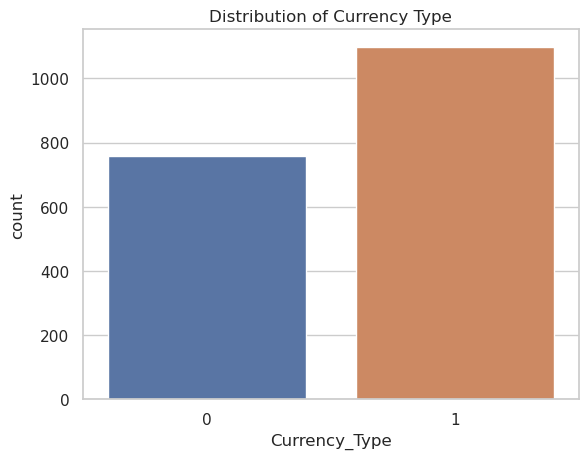

In [32]:
countdf = combined_df.groupBy("Currency_Type").count()

pandas_df = countdf.toPandas()
pandas_df

sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Currency_Type", y="count", data=pandas_df) #1 is crypto, 0 is stock
plt.title("Distribution of Currency Type")
plt.show()

#### Note about graphs

We have no scaled any of the features yet, so the volume and prices vary greatly depending on the type of currency. 

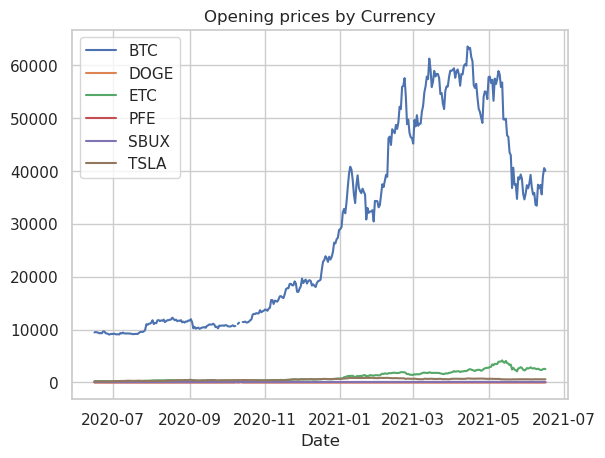

In [33]:
# Opening prices by each type 
df = combined_df.toPandas()

#define index column
df.set_index('Date', inplace=True)
#group data by product and display sales as line chart
df.groupby('Currency_Name')['Open'].plot(legend=True)
plt.title("Opening prices by Currency")
plt.show()

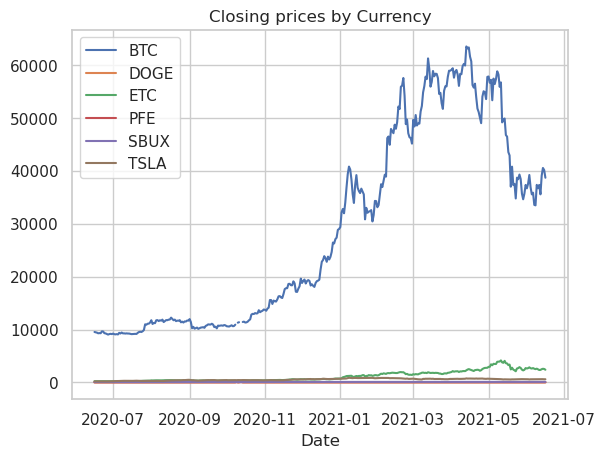

In [34]:
df = combined_df.toPandas()

#define index column
df.set_index('Date', inplace=True)
#group data by product and display sales as line chart
df.groupby('Currency_Name')['Close'].plot(legend=True)
plt.title("Closing prices by Currency")
plt.show()

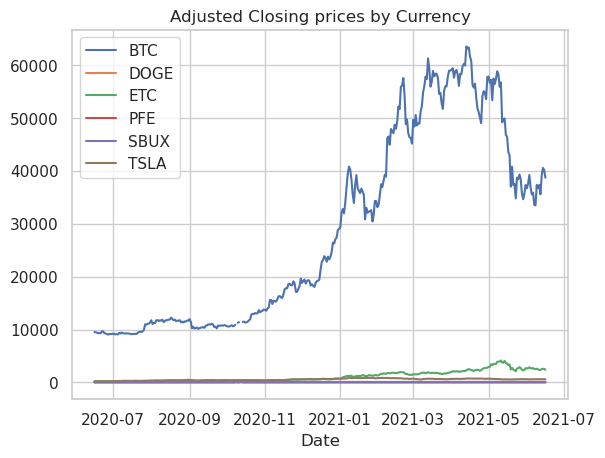

In [35]:
df = combined_df.toPandas()

#define index column
df.set_index('Date', inplace=True)
#group data by product and display sales as line chart
df.groupby('Currency_Name')['Adj Close'].plot(legend=True)
plt.title("Adjusted Closing prices by Currency")
plt.show()

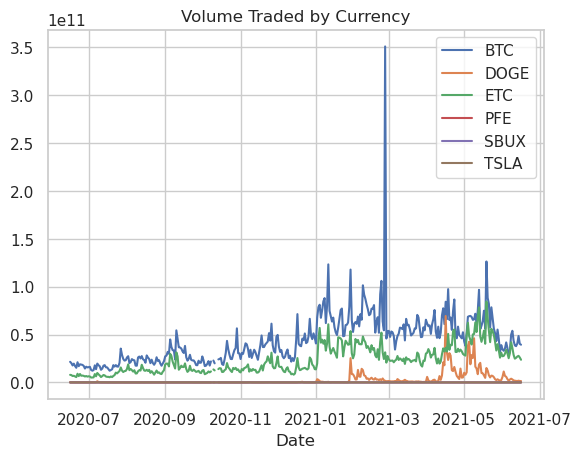

In [36]:
df = combined_df.toPandas()

#define index column
df.set_index('Date', inplace=True)
#group data by product and display sales as line chart
df.groupby('Currency_Name')['Volume'].plot(legend=True)
plt.title("Volume Traded by Currency")
plt.show()

#### Percentage Change Features

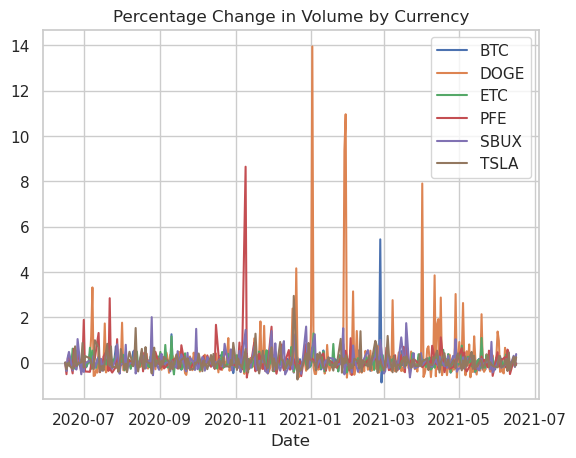

In [37]:
#percentage change in volume plot
df = combined_df.toPandas()

#define index column
df.set_index('Date', inplace=True)
#group data by product and display sales as line chart
df.groupby('Currency_Name')['perc_diff_volume'].plot(legend=True)
plt.title("Percentage Change in Volume by Currency")
plt.show()

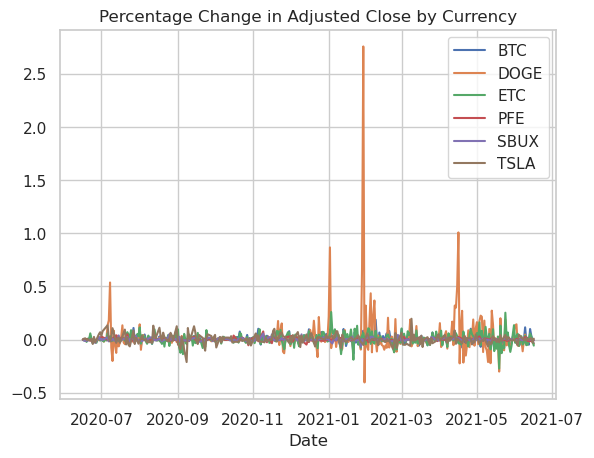

In [38]:
#percentage change in adju close plot
df = combined_df.toPandas()

#define index column
df.set_index('Date', inplace=True)
#group data by product and display sales as line chart
df.groupby('Currency_Name')['perc_diff_adjclose'].plot(legend=True)
plt.title("Percentage Change in Adjusted Close by Currency")
plt.show()

### Model Construction, Data Splitting, and Model Evaluation

We construct 3 different models to analyze our results: logistic regression, random forest, and K-means. We split the data using a seed in each model. We evaluate the models using various metrics at the end of each built model. A summarized version of the model metrics can be found in our corresponding paper. 

#### Logistic Regression

In [25]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [26]:
combined_df.show(10)

+----------+-------+-------+-------+-------+---------+-----------+-------------+-------------+---------------+--------------------+----------------+--------------------+---------------+--------------------+--------------+--------------------+-------------------+--------------------+-----------------+--------------------+
|      Date|   Open|   High|    Low|  Close|Adj Close|     Volume|Currency_Type|Currency_Name|prev_value_open|      perc_diff_open|prev_value_close|     perc_diff_close|prev_value_high|      perc_diff_high|prev_value_low|       perc_diff_low|prev_value_adjclose|  perc_diff_adjclose|prev_value_volume|    perc_diff_volume|
+----------+-------+-------+-------+-------+---------+-----------+-------------+-------------+---------------+--------------------+----------------+--------------------+---------------+--------------------+--------------+--------------------+-------------------+--------------------+-----------------+--------------------+
|2020-06-16| 202.37|202.576|192

In [27]:
# Number of rows with null values
combined_df.filter(combined_df.Open.isNull()).count()

9

In [28]:
# removing null values (if null in one column, null across all rows)
combined_df = combined_df.filter(combined_df.Open.isNotNull())

Note: using the pipeline method, while working with dataframes resulted in us not being able to get evaluation metrics other than the AUROC. Thus, we implement RDDs for most of the models we build.

In [29]:
training, test = combined_df.randomSplit([0.8, 0.2], seed=314)

In [30]:
predictors = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

assembler = VectorAssembler(inputCols=predictors,
                            outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

lr = LogisticRegression(labelCol='Currency_Type', featuresCol='scaledFeatures', maxIter=10, regParam=None) #instantiating model 

In [31]:
# Fit the pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr]) #not column names, using objects itself 
model = pipeline.fit(training) #only need to fit once, does every step in pipeline together 

In [32]:
prediction = model.transform(test)
prediction.select('Currency_Type', 'rawPrediction','probability','prediction').show(3, False)

+-------------+----------------------------------------+----------------------------------------+----------+
|Currency_Type|rawPrediction                           |probability                             |prediction|
+-------------+----------------------------------------+----------------------------------------+----------+
|0            |[1.23660446352838,-1.23660446352838]    |[0.77497241901909,0.22502758098091002]  |0.0       |
|0            |[1.2418930097997671,-1.2418930097997671]|[0.7758933481303883,0.22410665186961165]|0.0       |
|0            |[1.2530982144915315,-1.2530982144915315]|[0.7778357161342135,0.22216428386578646]|0.0       |
+-------------+----------------------------------------+----------------------------------------+----------+
only showing top 3 rows



In [35]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# set up evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction",
                                          labelCol="Currency_Type",
                                          metricName="areaUnderROC")

In [36]:
evaluator.evaluate(prediction)

0.890625

The accuracy in this logistic regression model is fairly high at 0.9563. In this model, we did not use percentage change, but instead used standard scalar to scale the data within the model pipeline. We believe that the accuracy in this model is reflective of the difference in scale of stock and crypto. If we were looking at other test data, this test data will also reflect this difference in scale due to the nature of which people trade stock and crypto. We think this is a good initial model in understanding the differences between stock and crypto. 

In [38]:
# with RDDs
predictors = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

assembler = VectorAssembler(inputCols=predictors,
                            outputCol="features")

transformed = assembler.transform(combined_df)

In [39]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

scalerModel = scaler.fit(transformed)
scaledData = scalerModel.transform(transformed)

In [40]:
dataRdd = scaledData.select("Currency_Type", "scaledFeatures").rdd.map(tuple)

In [41]:
dataRdd.take(5)

[(1, DenseVector([0.0165, 0.0165, 0.0171, 0.0169, 0.0169, 0.358])),
 (1, DenseVector([0.0169, 0.0165, 0.0171, 0.0168, 0.0168, 0.3461])),
 (1, DenseVector([0.0168, 0.0164, 0.0171, 0.0167, 0.0167, 0.3017])),
 (1, DenseVector([0.0167, 0.0162, 0.0169, 0.0163, 0.0163, 0.3122])),
 (1, DenseVector([0.0163, 0.0162, 0.0169, 0.0165, 0.0165, 0.281]))]

In [42]:
lp = dataRdd.map(lambda row:(1 if row[0]==1 else 0, Vectors.dense(row[1])))    \
                    .map(lambda row: LabeledPoint(row[0], row[1]))

In [43]:
lp.take(5)

[LabeledPoint(1.0, [0.016542371837416168,0.01650433870816151,0.017064982230052646,0.016855863173314254,0.016855604105891882,0.35798186908767804]),
 LabeledPoint(1.0, [0.016882926448330945,0.01647360201682773,0.01713337605118017,0.016756065680279167,0.016755808146701665,0.34610599387897406]),
 LabeledPoint(1.0, [0.01676818550433994,0.01637701666238456,0.017104224492999993,0.01668940125775733,0.01668914474878355,0.3017229688432917]),
 LabeledPoint(1.0, [0.016700239371961936,0.01620830150203067,0.016943137995930547,0.016332542135125944,0.01633229111092456,0.31217491527992175]),
 LabeledPoint(1.0, [0.016341790785426722,0.016159074004115703,0.016931591594147144,0.016486130671110315,0.01648587728631869,0.2810066505830164])]

In [44]:
training, test = lp.randomSplit([0.8, 0.2], seed=314)

In [45]:
model =  LogisticRegressionWithLBFGS.train(training, iterations=10, regType=None)

In [46]:
labelsAndPreds = test.map(lambda p: (p.label, model.predict(p.features)))
print(labelsAndPreds.take(20))

[(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1)]


In [47]:
labelsAndPreds = labelsAndPreds.map(lambda xs: [float(x) for x in xs])
print(labelsAndPreds.take(20))

[[1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0]]


In [55]:
metrics = MulticlassMetrics(labelsAndPreds)
print('accuracy:', metrics.accuracy)

accuracy: 0.9109195402298851


In [49]:
# confusion matrix
metrics.confusionMatrix().toArray()
#.       1  0
# pred1 TP FN
# pred0 FP TN

array([[ 98.,   0.],
       [ 31., 219.]])

In [74]:
Precision = 98 / (98 + 31)
Precision

0.7596899224806202

In [75]:
Recall = 98 / (98 + 0)
Recall

1.0

In [76]:
F1 = (2 * Precision * Recall) / (Precision + Recall)
F1

0.8634361233480177

The accuracy in this logistic regression model is fairly high at 0.91. In this model, we did not use percentage change, but instead used standard scalar to scale the data within the model pipeline. We believe that the accuracy in this model is reflective of the difference in scale of stock and crypto. If we were looking at other test data, this test data will also reflect this difference in scale due to the nature of which people trade stock and crypto. We think this is a good initial model in understanding the differences between stock and crypto. 

#### Logistic Regression with Percentage Change

In [115]:
df2 = combined_df.filter(combined_df.Open.isNotNull())

In [116]:
df2.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Currency_Type: integer (nullable = false)
 |-- Currency_Name: string (nullable = false)
 |-- prev_value_open: float (nullable = true)
 |-- perc_diff_open: double (nullable = true)
 |-- prev_value_close: float (nullable = true)
 |-- perc_diff_close: double (nullable = true)
 |-- prev_value_high: float (nullable = true)
 |-- perc_diff_high: double (nullable = true)
 |-- prev_value_low: float (nullable = true)
 |-- perc_diff_low: double (nullable = true)
 |-- prev_value_adjclose: float (nullable = true)
 |-- perc_diff_adjclose: double (nullable = true)
 |-- prev_value_volume: float (nullable = true)
 |-- perc_diff_volume: double (nullable = true)



In [117]:
predictors = ["perc_diff_open", "perc_diff_close", "perc_diff_high", "perc_diff_low", "perc_diff_adjclose", "perc_diff_volume"]

assembler2 = VectorAssembler(inputCols=predictors,
                            outputCol="features")

transformed2 = assembler2.transform(df2)

In [118]:
dataRdd2 = transformed2.select("Currency_Type", "features").rdd.map(tuple)

In [119]:
dataRdd2.take(5)

[(0, SparseVector(6, {})),
 (0, DenseVector([-0.0239, 0.0098, -0.0078, 0.021, 0.0098, -0.2961])),
 (0, DenseVector([0.0155, 0.0123, 0.0141, 0.0121, 0.0123, -0.014])),
 (0, DenseVector([0.0098, -0.003, -0.0032, -0.0031, -0.003, -0.1099])),
 (0, DenseVector([-0.0127, -0.0066, -0.007, -0.0013, -0.0066, -0.267]))]

In [120]:
lp2 = dataRdd2.map(lambda row:(1 if row[0]==1 else 0, Vectors.dense(row[1])))    \
                    .map(lambda row: LabeledPoint(row[0], row[1]))

In [121]:
training, test = lp2.randomSplit([0.8, 0.2], seed=314)

In [122]:
model =  LogisticRegressionWithLBFGS.train(training, iterations=10, regType=None)

In [123]:
labelsAndPreds = test.map(lambda p: (p.label, model.predict(p.features)))
print(labelsAndPreds.take(20))

[(0.0, 0), (0.0, 0), (0.0, 1), (0.0, 0), (0.0, 1), (0.0, 1), (0.0, 1), (0.0, 0), (0.0, 0), (0.0, 1), (0.0, 1), (0.0, 0), (0.0, 1), (0.0, 1), (0.0, 1), (0.0, 1), (0.0, 0), (0.0, 1), (0.0, 1), (0.0, 1)]


In [124]:
labelsAndPreds = labelsAndPreds.map(lambda xs: [float(x) for x in xs])
print(labelsAndPreds.take(20))

[[0.0, 0.0], [0.0, 0.0], [0.0, 1.0], [0.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 0.0], [0.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]


In [125]:
metricsbinary = BinaryClassificationMetrics(labelsAndPreds)
metricsbinary.areaUnderROC

0.47947478442644365

In [126]:
metrics = MulticlassMetrics(labelsAndPreds)
print('accuracy:', metrics.accuracy)

accuracy: 0.4860050890585242


In [127]:
# confusion matrix
metrics.confusionMatrix().toArray()

array([[ 73., 105.],
       [ 97., 118.]])

In [128]:
Precision = 73 / (73 + 97)
Precision

0.4294117647058823

In [129]:
Recall = 73 / (73 + 105)
Recall

0.4101123595505618

In [130]:
F1 = (2 * Precision * Recall) / (Precision + Recall)
F1

0.41954022988505746

The logistic regression model with percentage change features resulted in an accuracy much lower than the logistic regression model with raw features and standard scalar. We believe this is likely due to the standardization of features before feeding into the model. While percentage change was calculated by group (stock or crypto ticker), the percentage change is more minute and less of a difference between different groups.

#### Logistic Regularization (Ridge Regression)

In [106]:
model_ridge =  LogisticRegressionWithLBFGS.train(training, iterations=10, regType = 'l2')

In [107]:
labelsAndPreds = test.map(lambda p: (p.label, model_ridge.predict(p.features)))
print(labelsAndPreds.take(20))

[(0.0, 0), (0.0, 0), (0.0, 1), (0.0, 0), (0.0, 1), (0.0, 1), (0.0, 1), (0.0, 0), (0.0, 0), (0.0, 1), (0.0, 1), (0.0, 0), (0.0, 1), (0.0, 1), (0.0, 1), (0.0, 1), (0.0, 0), (0.0, 1), (0.0, 1), (0.0, 1)]


In [108]:
labelsAndPreds = labelsAndPreds.map(lambda xs: [float(x) for x in xs])
print(labelsAndPreds.take(20))

[[0.0, 0.0], [0.0, 0.0], [0.0, 1.0], [0.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 0.0], [0.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]


In [109]:
metricsbinary = BinaryClassificationMetrics(labelsAndPreds)
metricsbinary.areaUnderROC

0.47947478442644365

In [110]:
metrics = MulticlassMetrics(labelsAndPreds)
print('accuracy:', metrics.accuracy)

accuracy: 0.4860050890585242


In [111]:
# confusion matrix
metrics.confusionMatrix().toArray()

array([[ 73., 105.],
       [ 97., 118.]])

In [112]:
Precision = 73 / (73 + 97)
Precision

0.4294117647058823

In [113]:
Recall = 73 / (73 + 105)
Recall

0.4101123595505618

In [114]:
F1 = (2 * Precision * Recall) / (Precision + Recall)
F1

0.41954022988505746

#### Kmeans

#### Percentage Change for Volume (Raw)

In [40]:
import pandas as pd

In [41]:
df_pandas = combined_df.toPandas()

In [42]:
# perc_diff_open
volumedf = df_pandas[['Date', 'Currency_Name', 'Volume']]

In [43]:
volumedf_clean = volumedf.pivot_table(index=['Date'], 
                                  columns='Currency_Name', 
                                  values='Volume')
volumedf_clean = volumedf_clean.reset_index()
volumedf_clean = volumedf_clean.fillna(0)
volumedf_clean

Currency_Name,Date,BTC,DOGE,ETC,PFE,SBUX,TSLA
0,2020-06-16,2.156554e+10,1.962126e+08,7.965648e+09,55616944.0,10890100.0,70255504.0
1,2020-06-17,2.017771e+10,1.850835e+08,7.701391e+09,27509822.0,6906700.0,49454000.0
2,2020-06-18,1.777008e+10,1.713886e+08,6.713801e+09,32278856.0,8486000.0,48759500.0
3,2020-06-19,1.963222e+10,1.732810e+08,6.946373e+09,43986264.0,12538600.0,43398500.0
4,2020-06-20,1.713054e+10,1.582751e+08,6.252831e+09,0.0,0.0,0.0
...,...,...,...,...,...,...,...
361,2021-06-12,3.792423e+10,1.605634e+09,2.572436e+10,0.0,0.0,0.0
362,2021-06-13,4.066911e+10,1.484851e+09,2.709294e+10,0.0,0.0,0.0
363,2021-06-14,4.851313e+10,1.822191e+09,2.778349e+10,23408300.0,4222400.0,20424000.0
364,2021-06-15,4.023153e+10,1.504015e+09,2.607007e+10,20206900.0,3487300.0,17764100.0


In [44]:
tickers = list(volumedf_clean.columns[1:])
tickers

['BTC', 'DOGE', 'ETC', 'PFE', 'SBUX', 'TSLA']

In [45]:
dates = volumedf_clean.Date.values
dates[:5]

array([datetime.date(2020, 6, 16), datetime.date(2020, 6, 17),
       datetime.date(2020, 6, 18), datetime.date(2020, 6, 19),
       datetime.date(2020, 6, 20)], dtype=object)

In [46]:
del volumedf_clean['Date']

In [47]:
vals = volumedf_clean.values

In [48]:
vals_t = vals.transpose()

In [49]:
vals_t

array([[2.1565536e+10, 2.0177709e+10, 1.7770082e+10, ..., 4.8513126e+10,
        4.0231530e+10, 3.9433593e+10],
       [1.9621262e+08, 1.8508352e+08, 1.7138861e+08, ..., 1.8221911e+09,
        1.5040151e+09, 1.4607739e+09],
       [7.9656479e+09, 7.7013914e+09, 6.7138007e+09, ..., 2.7783487e+10,
        2.6070073e+10, 2.3705321e+10],
       [5.5616944e+07, 2.7509822e+07, 3.2278856e+07, ..., 2.3408300e+07,
        2.0206900e+07, 1.9177500e+07],
       [1.0890100e+07, 6.9067000e+06, 8.4860000e+06, ..., 4.2224000e+06,
        3.4873000e+06, 4.8220000e+06],
       [7.0255504e+07, 4.9454000e+07, 4.8759500e+07, ..., 2.0424000e+07,
        1.7764100e+07, 2.2144100e+07]], dtype=float32)

In [50]:
dft = pd.DataFrame(data=vals_t, index=volumedf_clean.columns, columns=dates)

In [51]:
dft

,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,...,2021-06-07,2021-06-08,2021-06-09,2021-06-10,2021-06-11,2021-06-12,2021-06-13,2021-06-14,2021-06-15,2021-06-16
Currency_Name,,,,,,,,,,,,,,,,,,,,,
BTC,2.156554e+10,2.017771e+10,1.777008e+10,1.963222e+10,1.713054e+10,1.532430e+10,2.110401e+10,1.700643e+10,1.896172e+10,1.861605e+10,...,3.368394e+10,4.990205e+10,5.397292e+10,4.357603e+10,3.869974e+10,3.792423e+10,4.066911e+10,4.851313e+10,4.023153e+10,3.943359e+10
DOGE,1.962126e+08,1.850835e+08,1.713886e+08,1.732810e+08,1.582751e+08,1.699178e+08,1.735308e+08,1.716048e+08,1.783808e+08,1.600034e+08,...,3.043975e+09,3.918488e+09,3.154333e+09,2.114010e+09,1.834447e+09,1.605634e+09,1.484851e+09,1.822191e+09,1.504015e+09,1.460774e+09
ETC,7.965648e+09,7.701391e+09,6.713801e+09,6.946373e+09,6.252831e+09,5.600408e+09,9.079587e+09,6.624530e+09,8.815030e+09,7.010426e+09,...,3.060011e+10,4.190974e+10,3.607583e+10,2.875363e+10,2.483256e+10,2.572436e+10,2.709294e+10,2.778349e+10,2.607007e+10,2.370532e+10
PFE,5.561694e+07,2.750982e+07,3.227886e+07,4.398626e+07,0.000000e+00,0.000000e+00,2.333250e+07,3.769041e+07,3.081770e+07,2.741865e+07,...,2.411070e+07,1.888030e+07,2.982400e+07,4.261370e+07,2.138690e+07,0.000000e+00,0.000000e+00,2.340830e+07,2.020690e+07,1.917750e+07
SBUX,1.089010e+07,6.906700e+06,8.486000e+06,1.253860e+07,0.000000e+00,0.000000e+00,8.238600e+06,8.076600e+06,1.230640e+07,8.624800e+06,...,4.009000e+06,4.669800e+06,3.669400e+06,3.833200e+06,3.231200e+06,0.000000e+00,0.000000e+00,4.222400e+06,3.487300e+06,4.822000e+06
TSLA,7.025550e+07,4.945400e+07,4.875950e+07,4.339850e+07,0.000000e+00,0.000000e+00,3.181200e+07,3.182650e+07,5.479800e+07,4.627250e+07,...,2.254370e+07,2.605340e+07,1.658460e+07,2.391960e+07,1.620530e+07,0.000000e+00,0.000000e+00,2.042400e+07,1.776410e+07,2.214410e+07


In [52]:
#dft.to_csv("rawvolume_transposed.csv")

In [68]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

df_vol = spark.read.csv('/project/ds5559/group5_NL_EL_CJ/rawvolume_transposed.csv', header=True, inferSchema=True)

In [69]:
datefeatures = df_vol.columns[1:]
assembler = VectorAssembler(inputCols=datefeatures, outputCol="features")
dataset=assembler.transform(df_vol)
dataset.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|[2.1565536E10,2.0...|
|[1.9621262E8,1.85...|
|[7.965648E9,7.701...|
|[5.5616944E7,2.75...|
|[1.08901E7,690670...|
+--------------------+
only showing top 5 rows



In [70]:
kmeans = KMeans().setK(2).setSeed(314).setMaxIter(10)
model = kmeans.fit(dataset)

In [71]:
predictions = model.transform(dataset)

In [72]:
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)

print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.745242010588722


In [73]:
def kmeans_range(lower_bound, upper_bound, df):

    silhouette_scores = []
    k_means = []

    for k in range(lower_bound, upper_bound+1):
        kmeans = KMeans().setK(k).setSeed(314).setMaxIter(10)
        model = kmeans.fit(df)
        predictions = model.transform(df)
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        silhouette_scores.append(silhouette)
        k_means.append(k)
    
    df_kmeans = pd.DataFrame({'k': k_means,
                             'silhouette_scores': silhouette_scores})
    
    return df_kmeans

In [74]:
df_kmeans = kmeans_range(2, 10, dataset)
df_kmeans

,k,silhouette_scores
0,2,0.745242
1,3,0.635162
2,4,0.499990
3,5,0.499990
4,6,0.499990
5,7,0.499990
6,8,0.499990
7,9,0.499990
8,10,0.499990


In [75]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Silhouette Scores by Cluster Numbers k')

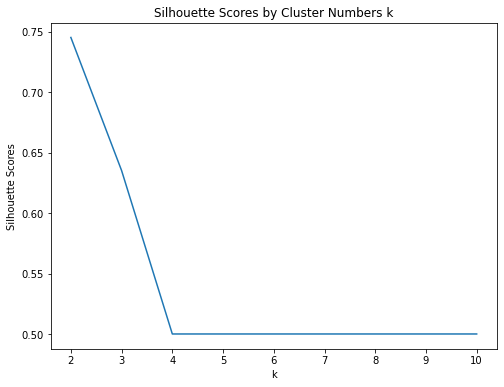

In [76]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(df_kmeans.k,df_kmeans.silhouette_scores)
ax.set_xlabel('k')
ax.set_ylabel('Silhouette Scores')
ax.set_title('Silhouette Scores by Cluster Numbers k')

In [78]:
KMeans_=KMeans(featuresCol='features', k=2) 
KMeans_Model=KMeans_.fit(dataset)
KMeans_Assignments=KMeans_Model.transform(dataset)

In [79]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(dataset)
pca_transformed = pca_model.transform(dataset)

In [80]:
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [81]:
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

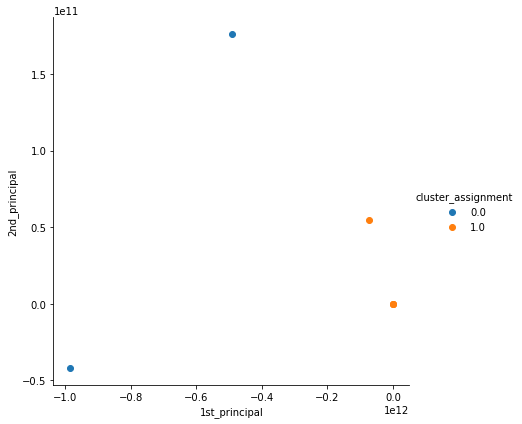

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

In [67]:
pca_df 

,1st_principal,2nd_principal,cluster_assignment
0,-9.863196e+11,-4.203876e+10,0.0
1,-7.337664e+10,5.491785e+10,1.0
2,-4.901264e+11,1.760024e+11,0.0
3,-3.957583e+08,2.076241e+07,1.0
4,-7.838817e+07,9.966075e+05,1.0
5,-5.020046e+08,1.671598e+07,1.0


#### KMeans for Percentage Difference Volume

In [128]:
df_pandas

,Date,Open,High,Low,Close,Adj Close,Volume,Currency_Type,Currency_Name,prev_value_open,...,prev_value_close,perc_diff_close,prev_value_high,perc_diff_high,prev_value_low,perc_diff_low,prev_value_adjclose,perc_diff_adjclose,prev_value_volume,perc_diff_volume
0,2020-06-16,202.369995,202.576004,192.477997,196.425995,196.425995,7.025550e+07,0,TSLA,NaN,...,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
1,2020-06-17,197.542007,201.000000,196.514008,198.358002,198.358002,4.945400e+07,0,TSLA,202.369995,...,196.425995,0.009836,202.576004,-0.007780,192.477997,0.020969,196.425995,0.009836,7.025550e+07,-0.296084
2,2020-06-18,200.600006,203.839996,198.893997,200.792007,200.792007,4.875950e+07,0,TSLA,197.542007,...,198.358002,0.012271,201.000000,0.014129,196.514008,0.012111,198.358002,0.012271,4.945400e+07,-0.014043
3,2020-06-19,202.556000,203.194000,198.268005,200.179993,200.179993,4.339850e+07,0,TSLA,200.600006,...,200.792007,-0.003048,203.839996,-0.003169,198.893997,-0.003147,200.792007,-0.003048,4.875950e+07,-0.109948
4,2020-06-22,199.990005,201.776001,198.003998,198.863998,198.863998,3.181200e+07,0,TSLA,202.556000,...,200.179993,-0.006574,203.194000,-0.006979,198.268005,-0.001332,200.179993,-0.006574,4.339850e+07,-0.266979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,2021-06-12,37340.144531,37408.925781,34728.191406,35552.515625,35552.515625,3.792423e+10,1,BTC,36697.031250,...,37334.398438,-0.047728,37608.695312,-0.005312,36044.449219,-0.036518,37334.398438,-0.047728,3.869974e+10,-0.020039
1844,2021-06-13,35555.789062,39322.781250,34864.109375,39097.859375,39097.859375,4.066911e+10,1,BTC,37340.144531,...,35552.515625,0.099721,37408.925781,0.051160,34728.191406,0.003914,35552.515625,0.099721,3.792423e+10,0.072378
1845,2021-06-14,39016.968750,40978.363281,38757.285156,40536.070312,40536.070312,4.851313e+10,1,BTC,35555.789062,...,39097.859375,0.036785,39322.781250,0.042102,34864.109375,0.111667,39097.859375,0.036785,4.066911e+10,0.192874
1846,2021-06-15,40526.781250,41295.269531,39609.468750,40155.296875,40155.296875,4.023153e+10,1,BTC,39016.968750,...,40536.070312,-0.009393,40978.363281,0.007734,38757.285156,0.021988,40536.070312,-0.009393,4.851313e+10,-0.170708


In [129]:
# perc_diff_open
volumedf = df_pandas[['Date', 'Currency_Name', 'perc_diff_volume']]

In [130]:
volumedf_clean = volumedf.pivot_table(index=['Date'], 
                                  columns='Currency_Name', 
                                  values='perc_diff_volume')
volumedf_clean = volumedf_clean.reset_index()
volumedf_clean = volumedf_clean.fillna(0)
volumedf_clean

Currency_Name,Date,BTC,DOGE,ETC,PFE,SBUX,TSLA
0,2020-06-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-06-17,-0.064354,-0.056720,-0.033175,-0.505370,-0.365782,-0.296084
2,2020-06-18,-0.119321,-0.073993,-0.128235,0.173358,0.228662,-0.014043
3,2020-06-19,0.104791,0.011041,0.034641,0.362696,0.477563,-0.109948
4,2020-06-20,-0.127427,-0.086599,-0.099842,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
361,2021-06-12,-0.020039,-0.124731,0.035913,0.000000,0.000000,0.000000
362,2021-06-13,0.072378,-0.075224,0.053202,0.000000,0.000000,0.000000
363,2021-06-14,0.192874,0.227187,0.025488,0.094516,0.306759,0.260328
364,2021-06-15,-0.170708,-0.174612,-0.061670,-0.136763,-0.174095,-0.130234


In [131]:
tickers = list(volumedf_clean.columns[1:])
tickers

['BTC', 'DOGE', 'ETC', 'PFE', 'SBUX', 'TSLA']

In [132]:
dates = volumedf_clean.Date.values
dates[:5]

array([datetime.date(2020, 6, 16), datetime.date(2020, 6, 17),
       datetime.date(2020, 6, 18), datetime.date(2020, 6, 19),
       datetime.date(2020, 6, 20)], dtype=object)

In [133]:
del volumedf_clean['Date']

In [134]:
vals = volumedf_clean.values

In [135]:
vals_t = vals.transpose()

In [136]:
vals_t

array([[ 0.        , -0.06435394, -0.11932112, ...,  0.19287393,
        -0.17070835, -0.01983364],
       [ 0.        , -0.05671961, -0.07399315, ...,  0.22718747,
        -0.17461176, -0.02875052],
       [ 0.        , -0.03317452, -0.12823536, ...,  0.02548791,
        -0.06167023, -0.09070753],
       [ 0.        , -0.50536977,  0.1733575 , ...,  0.0945158 ,
        -0.13676346, -0.05094299],
       [ 0.        , -0.36578177,  0.22866202, ...,  0.3067591 ,
        -0.1740953 ,  0.38273163],
       [ 0.        , -0.29608362, -0.01404335, ...,  0.26032841,
        -0.13023404,  0.2465647 ]])

In [137]:
dft = pd.DataFrame(data=vals_t, index=volumedf_clean.columns, columns=dates)

In [138]:
dft

,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,...,2021-06-07,2021-06-08,2021-06-09,2021-06-10,2021-06-11,2021-06-12,2021-06-13,2021-06-14,2021-06-15,2021-06-16
Currency_Name,,,,,,,,,,,,,,,,,,,,,
BTC,0.0,-0.064354,-0.119321,0.104791,-0.127427,-0.10544,0.377160,-0.194161,0.114973,-0.018230,...,0.164992,0.481479,0.081577,-0.192632,-0.111903,-0.020039,0.072378,0.192874,-0.170708,-0.019834
DOGE,0.0,-0.056720,-0.073993,0.011041,-0.086599,0.07356,0.021264,-0.011099,0.039486,-0.103023,...,0.657386,0.287293,-0.195013,-0.329807,-0.132243,-0.124731,-0.075224,0.227187,-0.174612,-0.028751
ETC,0.0,-0.033175,-0.128235,0.034641,-0.099842,-0.10434,0.621237,-0.270393,0.330665,-0.204719,...,0.208934,0.369594,-0.139202,-0.202967,-0.136368,0.035913,0.053202,0.025488,-0.061670,-0.090708
PFE,0.0,-0.505370,0.173358,0.362696,0.000000,0.00000,-0.469550,0.615361,-0.182346,-0.110295,...,0.244404,-0.216933,0.579636,0.428839,-0.498121,0.000000,0.000000,0.094516,-0.136763,-0.050943
SBUX,0.0,-0.365782,0.228662,0.477563,0.000000,0.00000,-0.342941,-0.019664,0.523710,-0.299161,...,-0.104634,0.164829,-0.214228,0.044639,-0.157049,0.000000,0.000000,0.306759,-0.174095,0.382732
TSLA,0.0,-0.296084,-0.014043,-0.109948,0.000000,0.00000,-0.266979,0.000456,0.721773,-0.155580,...,-0.062121,0.155684,-0.363438,0.442278,-0.322510,0.000000,0.000000,0.260328,-0.130234,0.246565


In [140]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

df_volume = spark.read.csv('/project/ds5559/group5_NL_EL_CJ/transformed_volume_percentage.csv', header=True, inferSchema=True)

In [141]:
stockfeatures = df_volume.columns[1:]
assembler = VectorAssembler(inputCols=stockfeatures, outputCol="features")
dataset=assembler.transform(df_volume)
dataset.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|[0.0,-0.064353938...|
|[0.0,-0.056719612...|
|[0.0,-0.033174515...|
|[0.0,-0.505369766...|
|[0.0,-0.365781765...|
+--------------------+
only showing top 5 rows



In [142]:
kmeans = KMeans().setK(2).setSeed(314).setMaxIter(10)
model = kmeans.fit(dataset)

In [143]:
predictions = model.transform(dataset)

In [144]:
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)

print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7128068377377695


In [145]:
def kmeans_range(lower_bound, upper_bound, df):

    silhouette_scores = []
    k_means = []

    for k in range(lower_bound, upper_bound+1):
        kmeans = KMeans().setK(k).setSeed(314).setMaxIter(10)
        model = kmeans.fit(df)
        predictions = model.transform(df)
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        silhouette_scores.append(silhouette)
        k_means.append(k)
    
    df_kmeans = pd.DataFrame({'k': k_means,
                             'silhouette_scores': silhouette_scores})
    
    return df_kmeans

In [146]:
df_kmeans = kmeans_range(2, 10, dataset)
df_kmeans

,k,silhouette_scores
0,2,0.712807
1,3,0.334380
2,4,-0.002836
3,5,-0.062035
4,6,0.000000
5,7,0.000000
6,8,0.000000
7,9,0.000000
8,10,0.000000


In [147]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Silhouette Scores by Cluster Numbers k')

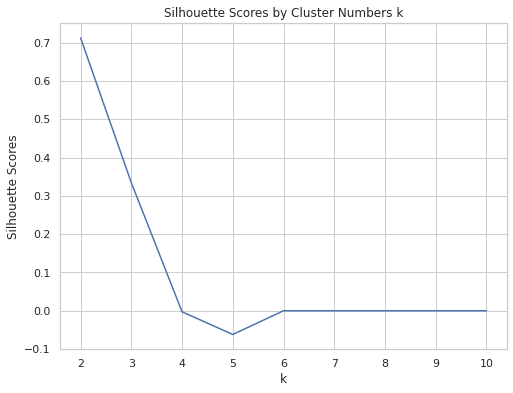

In [148]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(df_kmeans.k,df_kmeans.silhouette_scores)
ax.set_xlabel('k')
ax.set_ylabel('Silhouette Scores')
ax.set_title('Silhouette Scores by Cluster Numbers k')

In [149]:
KMeans_=KMeans(featuresCol='features', k=2) 
KMeans_Model=KMeans_.fit(dataset)
KMeans_Assignments=KMeans_Model.transform(dataset)

In [150]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(dataset)
pca_transformed = pca_model.transform(dataset)

In [151]:
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [152]:
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

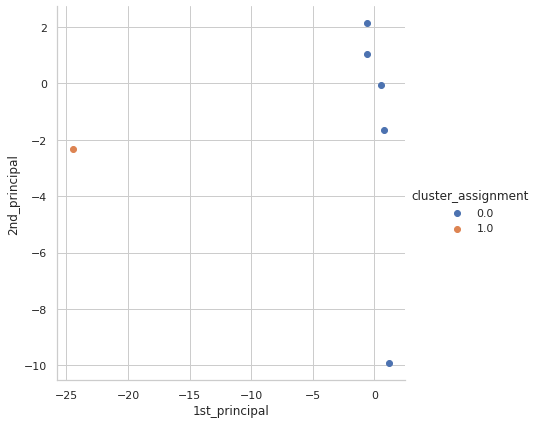

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

### Random Forests

In [28]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#### Setting up Random Forests

In [29]:
combined_df = combined_df.filter(combined_df.Open.isNotNull())

In [30]:
numericCols = ["Open", "High", "Low", "Close", "Adj Close", "Volume", "perc_diff_open", "perc_diff_close", "perc_diff_high", "perc_diff_low", "perc_diff_adjclose", "perc_diff_volume"]
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
transformed = assembler.transform(combined_df)

In [31]:
label_stringIdx = StringIndexer(inputCol = 'Currency_Type', outputCol = 'labelIndex')
transformed = label_stringIdx.fit(transformed).transform(transformed)
transformed.show(5, truncate=True)

+----------+-------+-------+-------+-------+---------+-----------+-------------+-------------+---------------+--------------------+----------------+--------------------+---------------+--------------------+--------------+--------------------+-------------------+--------------------+-----------------+--------------------+--------------------+----------+
|      Date|   Open|   High|    Low|  Close|Adj Close|     Volume|Currency_Type|Currency_Name|prev_value_open|      perc_diff_open|prev_value_close|     perc_diff_close|prev_value_high|      perc_diff_high|prev_value_low|       perc_diff_low|prev_value_adjclose|  perc_diff_adjclose|prev_value_volume|    perc_diff_volume|            features|labelIndex|
+----------+-------+-------+-------+-------+---------+-----------+-------------+-------------+---------------+--------------------+----------------+--------------------+---------------+--------------------+--------------+--------------------+-------------------+--------------------+-------

#### Pipeline

In [36]:
cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume", "perc_diff_open", "perc_diff_close", "perc_diff_high", "perc_diff_low", "perc_diff_adjclose", "perc_diff_volume"]

assembler = VectorAssembler()\
  .setInputCols(cols)\
  .setOutputCol("features")
featureDf = assembler.transform(combined_df)

In [37]:
indexer = StringIndexer()\
  .setInputCol("Currency_Type")\
  .setOutputCol("label")
labelDf = indexer.fit(featureDf).transform(featureDf)

### Cross-Validated Random Forest with all Features

In [41]:
pipelineTrainingData, pipelineTestingData = combined_df.randomSplit([0.8, 0.2], seed=314)

# // VectorAssembler and StringIndexer are transformers
# // LogisticRegression is the estimator
stages = np.array([assembler, indexer, randomForestClassifier])

# // build pipeline
pipeline = Pipeline().setStages(stages)
pipelineModel = pipeline.fit(pipelineTrainingData)

# // test model with test data
pipelinePredictionDf = pipelineModel.transform(pipelineTestingData)

In [42]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [43]:
evaluator = BinaryClassificationEvaluator()\
  .setLabelCol("label")\
  .setMetricName("areaUnderROC")

In [44]:
paramGrid = ParamGridBuilder()\
  .addGrid(randomForestClassifier.maxBins, [5,10,15])\
  .addGrid(randomForestClassifier.maxDepth, [3,4,5])\
  .addGrid(randomForestClassifier.impurity, ["entropy", "gini"])\
  .build()

# Define cross validation stage to search through the parameters
# K-Fold cross validation with BinaryClassificationEvaluator
cv = CrossValidator()\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)\
  .setEstimatorParamMaps(paramGrid)\
  .setNumFolds(3)

In [45]:
cvModel = cv.setParallelism(4).fit(pipelineTrainingData)

# Test cross validated model with test data
cvPredictionDf = cvModel.transform(pipelineTestingData)
cvPredictionDf.show(10)

+----------+-------+-------+-------+-------+---------+------------+-------------+-------------+---------------+--------------------+----------------+--------------------+---------------+--------------------+--------------+--------------------+-------------------+--------------------+-----------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|      Date|   Open|   High|    Low|  Close|Adj Close|      Volume|Currency_Type|Currency_Name|prev_value_open|      perc_diff_open|prev_value_close|     perc_diff_close|prev_value_high|      perc_diff_high|prev_value_low|       perc_diff_low|prev_value_adjclose|  perc_diff_adjclose|prev_value_volume|    perc_diff_volume|            features|label|       rawPrediction|         probability|prediction|
+----------+-------+-------+-------+-------+---------+------------+-------------+-------------+---------------+--------------------+----------------+--------------------+---------------+------

In [46]:
auroc = evaluator.evaluate(cvPredictionDf)
print(auroc)

1.0


In [47]:
metrics = MulticlassClassificationEvaluator()\
  .setLabelCol("label")

In [48]:
metrics.evaluate(cvPredictionDf, {metrics.metricName: "accuracy"})

1.0

In [49]:
metrics.evaluate(cvPredictionDf, {metrics.metricName: "f1"})

1.0

In [50]:
metrics.evaluate(cvPredictionDf, {metrics.metricName: "weightedPrecision"})

1.0

In [52]:
metrics.evaluate(cvPredictionDf, {metrics.metricName: "weightedRecall"})

1.0

In [56]:
#extracting parameters for best CV model
cvModel.bestModel.stages[-1]

RandomForestClassificationModel: uid=RandomForestClassifier_1d9e1422472b, numTrees=20, numClasses=2, numFeatures=12

### Cross-Validation on Random Forest for percentage difference

In [70]:
pipelineTrainingData, pipelineTestingData = combined_df.randomSplit([0.8, 0.2], seed=314)

# // VectorAssembler and StringIndexer are transformers
# // LogisticRegression is the estimator
stages = np.array([assembler, indexer, randomForestClassifier])

# // build pipeline
pipeline = Pipeline().setStages(stages)
pipelineModel = pipeline.fit(pipelineTrainingData)

# // test model with test data
pipelinePredictionDf = pipelineModel.transform(pipelineTestingData)
pipelinePredictionDf.show(10)

+----------+-------+-------+-------+-------+---------+------------+-------------+-------------+---------------+--------------------+----------------+--------------------+---------------+--------------------+--------------+--------------------+-------------------+--------------------+-----------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|      Date|   Open|   High|    Low|  Close|Adj Close|      Volume|Currency_Type|Currency_Name|prev_value_open|      perc_diff_open|prev_value_close|     perc_diff_close|prev_value_high|      perc_diff_high|prev_value_low|       perc_diff_low|prev_value_adjclose|  perc_diff_adjclose|prev_value_volume|    perc_diff_volume|            features|label|       rawPrediction|         probability|prediction|
+----------+-------+-------+-------+-------+---------+------------+-------------+-------------+---------------+--------------------+----------------+--------------------+---------------+------

In [71]:
paramGrid = ParamGridBuilder()\
  .addGrid(randomForestClassifier.maxBins, [5,10,15])\
  .addGrid(randomForestClassifier.maxDepth, [3,4,5])\
  .addGrid(randomForestClassifier.impurity, ["entropy", "gini"])\
  .build()

# Define cross validation stage to search through the parameters
# K-Fold cross validation with BinaryClassificationEvaluator
cv = CrossValidator()\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)\
  .setEstimatorParamMaps(paramGrid)\
  .setNumFolds(3)

In [72]:
cvModel = cv.setParallelism(4).fit(pipelineTrainingData)

# Test cross validated model with test data
cvPredictionDf = cvModel.transform(pipelineTestingData)
cvPredictionDf.show(10)

+----------+-------+-------+-------+-------+---------+------------+-------------+-------------+---------------+--------------------+----------------+--------------------+---------------+--------------------+--------------+--------------------+-------------------+--------------------+-----------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|      Date|   Open|   High|    Low|  Close|Adj Close|      Volume|Currency_Type|Currency_Name|prev_value_open|      perc_diff_open|prev_value_close|     perc_diff_close|prev_value_high|      perc_diff_high|prev_value_low|       perc_diff_low|prev_value_adjclose|  perc_diff_adjclose|prev_value_volume|    perc_diff_volume|            features|label|       rawPrediction|         probability|prediction|
+----------+-------+-------+-------+-------+---------+------------+-------------+-------------+---------------+--------------------+----------------+--------------------+---------------+------

In [74]:
auroc = evaluator.evaluate(cvPredictionDf)
print(auroc)

0.751408197507191


In [75]:
metrics = MulticlassClassificationEvaluator()\
  .setLabelCol("label")

In [76]:
metrics.evaluate(cvPredictionDf, {metrics.metricName: "accuracy"})

0.710455764075067

In [77]:
metrics.evaluate(cvPredictionDf, {metrics.metricName: "f1"})

0.7097672445808141

In [78]:
metrics.evaluate(cvPredictionDf, {metrics.metricName: "weightedPrecision"})

0.7092438964657646

In [79]:
metrics.evaluate(cvPredictionDf, {metrics.metricName: "weightedRecall"})

0.710455764075067

In [80]:
trueandpredicted = cvPredictionDf.select(['label', 'prediction']).toPandas()
trueandpredicted

,label,prediction
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,0.0
4,1.0,0.0
...,...,...
368,0.0,0.0
369,0.0,0.0
370,0.0,0.0
371,0.0,0.0


In [81]:
confusion_matrix = pd.crosstab(trueandpredicted['label'], trueandpredicted['prediction'], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted  0.0  1.0
Actual             
0.0        172   52
1.0         56   93


In [98]:
#extracting parameters for best CV model
cvModel.bestModel.stages[-1]

RandomForestClassificationModel: uid=RandomForestClassifier_ef5f28adfa54, numTrees=20, numClasses=2, numFeatures=6